In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import glob 

batch_size = '' # Change to _2048 to test other experiment

In [3]:
pretrain_times = glob.glob(f'../pretrained/rw_sampling/epoch_ablation{batch_size}/**/rw_bert_lanl14argus_log_tiny.txt')

tr_lens = [1,2,3,5,7,9,10]

tr_len_to_log = dict()
for f in pretrain_times: 
    epoch = int(f.split('/')[-2].split('e')[0])
    df = pd.read_csv(f, names=['loss', 'epoch', 'tokens', 'time'])
    tr_len_to_log[epoch] = df 

times = [tr_len_to_log[i]['time'].sum() for i in tr_lens]
times[-1] = times[-2]/0.9 # Error in logging 1e9 so have to extrapolate

times

[1245.5383911132812,
 2485.8059775829315,
 3732.9261951446533,
 6242.31200504303,
 8709.146009922028,
 11197.150902032852,
 12441.278780036502]

In [4]:
result_folders = glob.glob(f'../results/rw/lanl14argus/epoch_ablation{batch_size}/*')

tr_len_to_ap = dict()
for dir in result_folders: 
    epoch = int(dir.split('/')[-1].split('e')[0])
    files = glob.glob(f'{dir}/*.txt')

    best = 0
    for file in files: 
        with open(file, 'r') as f: 
            result = f.read()
        
        # Some files have headers, others dont
        try: 
            line = result.split('\n')[3] # 5 epochs
            vals = line.split(',')
            ap = vals[3]

            v_auc = float(vals[4])
            ap = float(ap)
            best = max(best,ap)

        except: 
            pass 

    tr_len_to_ap[epoch] = best

aps = [tr_len_to_ap[i] for i in tr_lens]
aps 

[0.4741883665940638,
 0.16645091133152481,
 0.5101368881164065,
 0.4257665358629622,
 0.6476656202042821,
 0.8143342397527215,
 0.837058323393419]

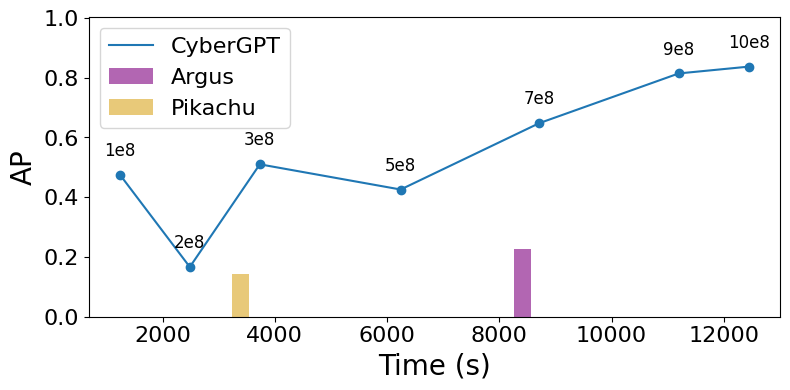

In [14]:
import numpy as np 

tokens = [tr * 1e8 for tr in tr_lens]
fig, ax = plt.subplots(figsize=(8, 4))

# Main line (y vs. times)
ax.plot(times, aps, label='CyberGPT')

ax.bar(8415, 0.2279, width=300, color='purple', alpha=0.6, label='Argus')
ax.bar(3390, 0.1428, width=300, color='goldenrod', alpha=0.6, label='Pikachu')

# Labeling
ax.set_xlabel("Time (s)", size=20)
ax.set_ylabel("AP", size=20)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

for i,t in enumerate(tr_lens): 
    plt.scatter(times[i], aps[i], color='C0')
    plt.text(times[i], aps[i]+0.05, f'{t}e8', ha='center', va='bottom', fontsize=12, color='black')

#def time_to_trlen(x): return np.interp(x, times, tokens)
#def trlen_to_time(x): return np.interp(x, tokens, times)

#secax = ax.secondary_xaxis('top', functions=(time_to_trlen, trlen_to_time))
#secax.set_xlabel("Training Tokens", size=20)
#secax.tick_params(axis='x', labelsize=16)

plt.margins(None, 0.2)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()